In [1]:
import os
os.getcwd()

'/home/yotamfr/development/prot2vec/src/python'

In [2]:
from src.python.preprocess2 import *

from Bio.SeqIO import parse as parse_fasta

   
def load_targets(fpath):
    num_seq = count_lines(fpath, sep=bytes('>', 'utf8'))
    fasta_src = parse_fasta(open(fpath, 'r'), 'fasta')
    return FastaFileLoader(fasta_src, num_seq).load()
    
target_fname1 = "../../Data/CAFA_PI/targetFiles/target.208963.fasta"
target_fname2 = "../../Data/CAFA_PI/targetFiles/target.237561.fasta"

targets1 = load_targets(target_fname1)
targets2 = load_targets(target_fname2)


40%

81%

100%
Finished loading 5892 sequences!
100%
Finished loading 12421 sequences!


In [3]:
%matplotlib inline  
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import matplotlib.pyplot as plt

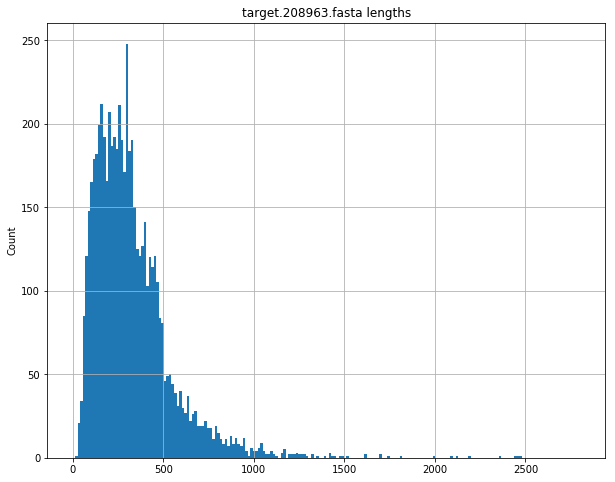

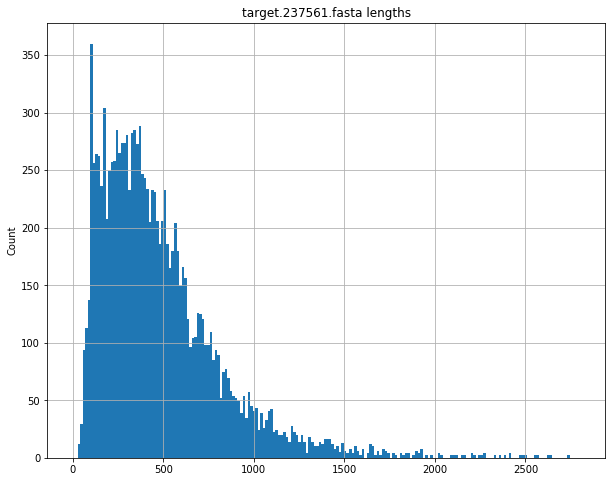

In [4]:
plt.hist(list(map(lambda seq: len(seq), targets1.values())), bins=200, range=(0, 2800))
plt.title("target.208963.fasta lengths")
plt.ylabel("Count")
plt.grid(True)
plt.show()


plt.hist(list(map(lambda seq: len(seq), targets2.values())), bins=200, range=(0, 2800))
plt.title("target.237561.fasta lengths")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [5]:
from src.python.preprocess2 import *

from pymongo import MongoClient

asp = 'F'  # default: Molecular Function

client = MongoClient('mongodb://127.0.0.1:27017')

db = client['prot2vec']

print("Loading Ontology...")
onto = get_ontology(asp)

classes = onto.classes
classes.remove(onto.root)
assert onto.root not in classes

Loading Ontology...


In [6]:
print("Indexing Data...")
trn_stream, tst_stream = get_training_and_validation_streams(db, t0, t1, asp, profile=0)

Indexing Data...
100%
Finished loading 81630 mappings!
100%
Finished loading 7909 mappings!


In [7]:
seqs_valid = {k: str(seq) for k, seq, _ in tst_stream}
annots_valid = {k: onto.propagate(v, include_root=False) for k, v in tst_stream._seq2go.items()}
seqs_train = {k: str(seq) for k, seq, _ in trn_stream}
annots_train = {k: onto.propagate(v, include_root=False) for k, v in trn_stream._seq2go.items()}

assert 0 == len(set(trn_stream._seq2go.keys()) & set(tst_stream._seq2go.keys()))

In [8]:
from src.python import baselines

ASPECT = 'F'  # Molecular Function

baselines.init_GO(asp=ASPECT)

/home/yotamfr/development/prot2vec/virtualenv/lib/python3.6/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


targets processed: 100%|██████████| 2893/2893 [00:00<00:00, 137307.31it/s]


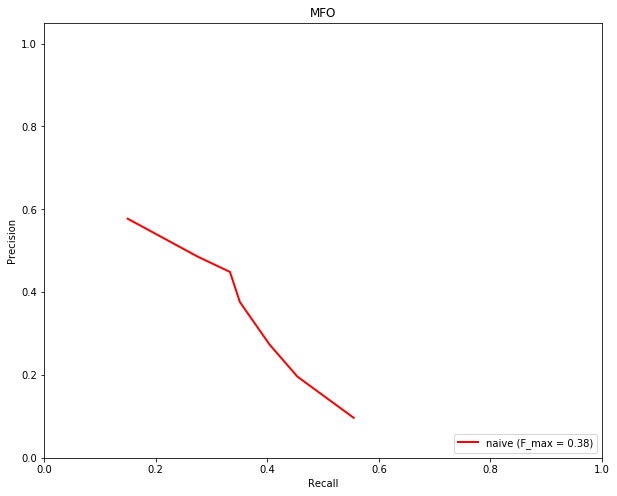

In [9]:
y_naive = baselines.predict(seqs_train, annots_train, seqs_valid, "naive")
perf_naive = baselines.performance(y_naive, annots_valid)
baselines.plot_precision_recall({"naive": perf_naive})

In [10]:
for go, prob in sorted([(go, prob) for go, prob in baselines.PRIOR.items()], key=lambda kv: kv[1])[-20:]:
    print(go, prob)

GO:0004871 0.0695376792524365
GO:0016773 0.06978300140502687
GO:0015075 0.07413189411003814
GO:0140110 0.07865920292602421
GO:0016301 0.0789045250786146
GO:0016491 0.08604116951760744
GO:0016772 0.09467204888601441
GO:0022857 0.09884252548005085
GO:0003677 0.10412810276767992
GO:0005215 0.10867771359753786
GO:0043167 0.11639421039719887
GO:0140096 0.1344588416333995
GO:0003676 0.14971341912174668
GO:0016787 0.17538303708824907
GO:1901363 0.1971275006133054
GO:0016740 0.1971721046410491
GO:0097159 0.20067352081892995
GO:0003824 0.518008876201521
GO:0005515 0.6687704899752448
GO:0005488 1.0068913222864024


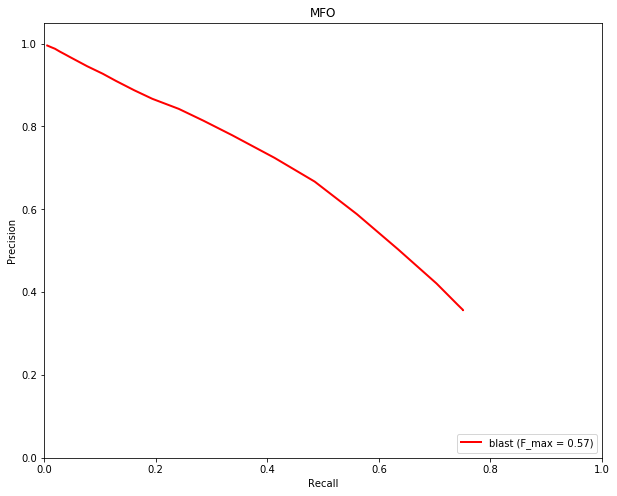

In [11]:
y_blast = baselines.predict(seqs_train, annots_train, seqs_valid, "blast", basename="cafa2")
thresholds = np.concatenate([np.arange(.05, 1, .05), np.arange(.96, 1, .01)])
perf_blast = baselines.performance(y_blast, annots_valid, ths=thresholds)
baselines.plot_precision_recall({"blast": perf_blast})

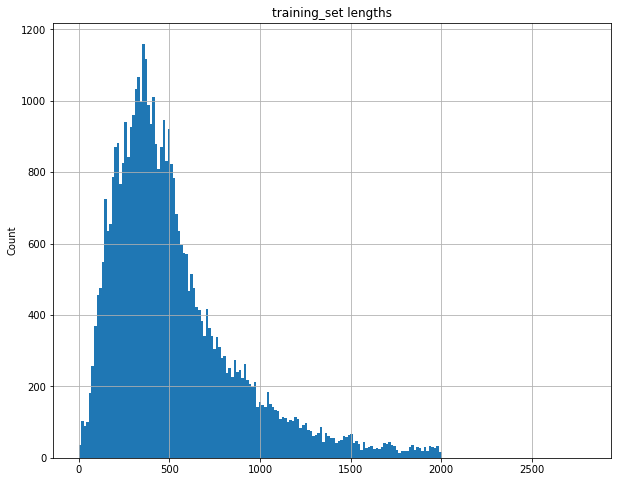

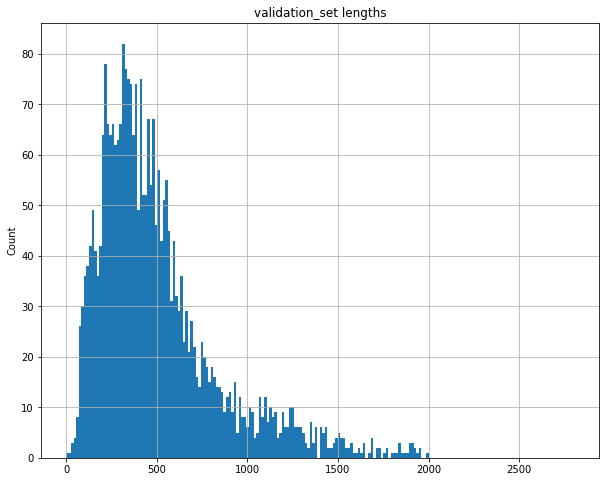

In [12]:
plt.hist(list(map(lambda seq: len(seq), seqs_train.values())), bins=200, range=(0, 2800))
plt.title("training_set lengths")
plt.ylabel("Count")
plt.grid(True)
plt.show()


plt.hist(list(map(lambda seq: len(seq), seqs_valid.values())), bins=200, range=(0, 2800))
plt.title("validation_set lengths")
plt.ylabel("Count")
plt.grid(True)
plt.show()

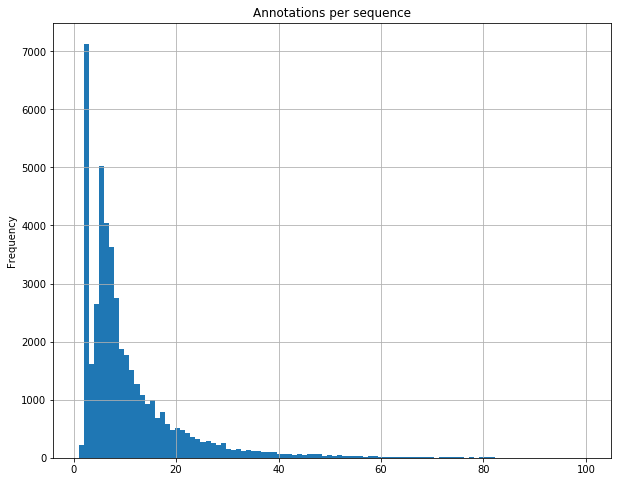

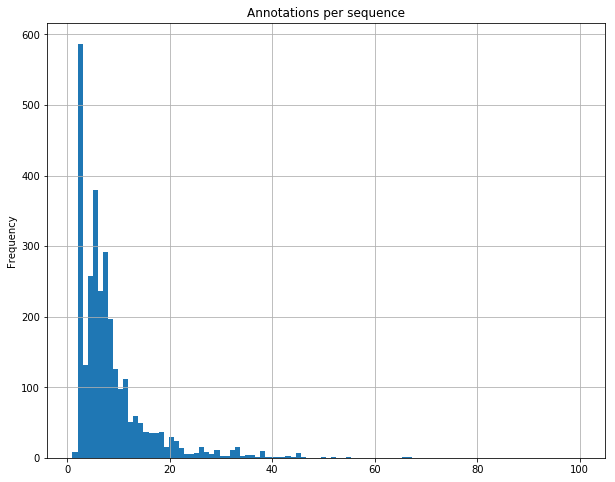

In [13]:
plt.hist(list(map(lambda annos: len(annos), annots_train.values())), bins=100, range=(1, 100))
plt.title("Annotations per sequence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


plt.hist(list(map(lambda annos: len(annos), annots_valid.values())), bins=100, range=(1, 100))
plt.title("Annotations per sequence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [14]:
from src.python.deepseq0 import *

from keras.models import model_from_json

client = MongoClient("mongodb://localhost:27017/")

db = client['prot2vec']

print("Loading Ontology...")
onto = get_ontology(ASPECT)

# model_str_deeperseq = "deeperseq-6-0.00258-0.72"
# model_str_deeperseq = "deeperseq-9-0.00250-0.63"
# model_str_deeperseq = "deeperseq-11-0.00250-0.57"
model_str_deeperseq = "deeperseq-20-0.00241-0.56"

classes = onto.classes
classes.remove(onto.root)
assert onto.root not in classes

with open('../../checkpoints/%s.json' % model_str_deeperseq, 'r') as f:
    deeperseq = model_from_json(f.read())
    
deeperseq.load_weights("../../checkpoints/%s.hdf5" % model_str_deeperseq)
print("Loaded model from disk")


/home/yotamfr/development/prot2vec/virtualenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Loading Ontology...
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Loaded model from disk


In [15]:
# def predict(model, gen_xy, length_xy, classes, classes_seen=None):
#     pbar = tqdm(total=length_xy, desc="Predicting...")
#     i, m, n = 0, length_xy, len(classes)
#     y_pred, y_true = np.zeros((m, n)), np.zeros((m, n))
#     for i, (X, Y) in enumerate(gen_xy):
#         assert len(X) == len(Y)
#         k = len(Y)
#         pbar.update(k)
#         y_hat, y = model.predict(X), Y
#         y_pred[i:i + k, ] = y_hat
#         y_true[i:i + k, ] = y
#         if not classes_seen:
#             continue
#         for j, c in enumerate(classes):
#             if c not in classes_seen:
#                 y_pred[i:i + k, j] = 0
#     pbar.close()
#     return y_true, y_pred

In [16]:
trn_stream, tst_stream = get_training_and_validation_streams(db, onto, classes, limit=None)
# classes_seen = get_classes(trn_stream._seq2go, onto)
y_true, y_dummyseq = predict_dummy(deeperseq, batch_generator(tst_stream), len(tst_stream), classes)
perf_dummyseq = baselines.performance(y_dummyseq, y_true, classes)

100%
Finished loading 7909 mappings!
100%
Finished loading 81630 mappings!


Predicting...:  97%|█████████▋| 5389/5528 [11:10<00:23,  5.82it/s]


In [17]:
trn_stream, tst_stream = get_training_and_validation_streams(db, onto, classes, limit=None)
# classes_seen = get_classes(onto, trn_stream._seq2go, {})
y_true, y_deeperseq = predict(deeperseq, batch_generator(tst_stream), len(tst_stream), classes)
perf_deeperseq = baselines.performance(y_deeperseq, y_true, classes)

100%
Finished loading 7909 mappings!
100%
Finished loading 81630 mappings!


Predicting...:  97%|█████████▋| 5389/5528 [11:34<00:20,  6.80it/s]


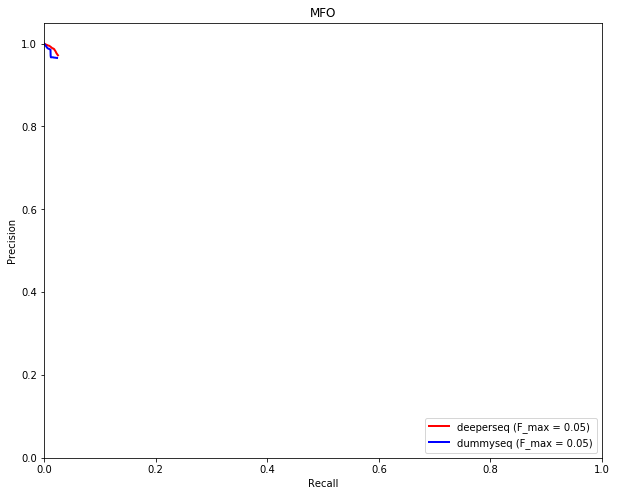

In [18]:
baselines.plot_precision_recall({"deeperseq": perf_deeperseq, "dummyseq": perf_dummyseq})

In [19]:
count_training = np.zeros(len(classes))

for k, v in trn_stream._seq2go.items():
    for go in v:
        if go == 'GO:0003674':
            continue
        count_training[classes.index(go)] += 1
        
th = 0.1   
count_dummy = np.sum(y_dummyseq > th, axis=0)
plt.plot(count_training, count_dummy, 'ro')
# plt.axis([0, 10000, 0, 200])
plt.xlabel('Saw-in-Training count')
plt.ylabel('Dummy count')
plt.show()

ValueError: 'GO:0015266' is not in list

In [ ]:
len(count_training), len(count_dummy), sum(count_training), sum(count_dummy)

In [ ]:
from src.python import baselines

eps = 10e-4

deeperseq_pred = dict(zip(y_blast.keys(), y_deeperseq))
for seqid, y in deeperseq_pred.items(): 
    deeperseq_pred[seqid] = {go: prob for go, prob in baselines.bin2dict(y, classes).items() if prob > eps}
    
print("computing product of experts...")
blast_pred = baselines.predict(seqs_train, annots_train, seqs_valid, "blast", filename="cafa2")
y_poe = product_of_experts(deeperseq_pred, blast_pred)
perf_poe = baselines.performance(y_poe, annots_valid)

In [ ]:
baselines.plot_precision_recall({"naive": perf_naive, "blast": perf_blast, "deeperseq": perf_deeperseq, "dummyseq": perf_dummyseq, "deeperseq+blast": perf_poe})